# End-to-End Deep Learning
_____________________________________________

## 1. Introduction - ORIGINAL SAMPLE
_______________________

In this notebook, we will go through the entire life cycle of a deep learning model from data to deployment. We will train, analyze, and deploy a classification model using the Tensorflow API. After the model has been trained, we will use Descartes Labs APIs to deploy our model over an area of interest.

---

**Note:** We recommend using a GPU to execute this notebook.  There is a deep learning training step that takes 1.5 minutes on a GPU but closer to 1.5 hours when using CPU resources.  If you are executing this notebook on the Descartes Labs Workbench, you can launch a GPU-enabled server with `File -> Hub Control Panel ->  Stop my Server -> Start my Server` and then select the GPU option.

---

In this demo, we will use the following Descartes Labs interfaces:
- Downloading images from `Catalog` with `Scenes`
- Uploading and downloading models with `Storage`
- Creating, uploading, and downloading custom user data from `Catalog`
- Distributed computing with `Tasks`
- Interacting with the data using `Workflows`

~~In this tutorial, we will train and deploy a deep-learning computer vision model to detect sites for oil and gas extraction in the Permian Basin known as "well pads." We will train a UNet segmentation model to detect well pads using imagery from the National Aerial Imagery Program (NAIP).~~

In this tutorial, we will train and deploy a deep-learning computer vision model to detect slum areas. We will train a UNet segmentation model to detect slums using imagery from the Airbus Pleaides VHR dataset.

You can run the following cells using `Shift-Enter`.

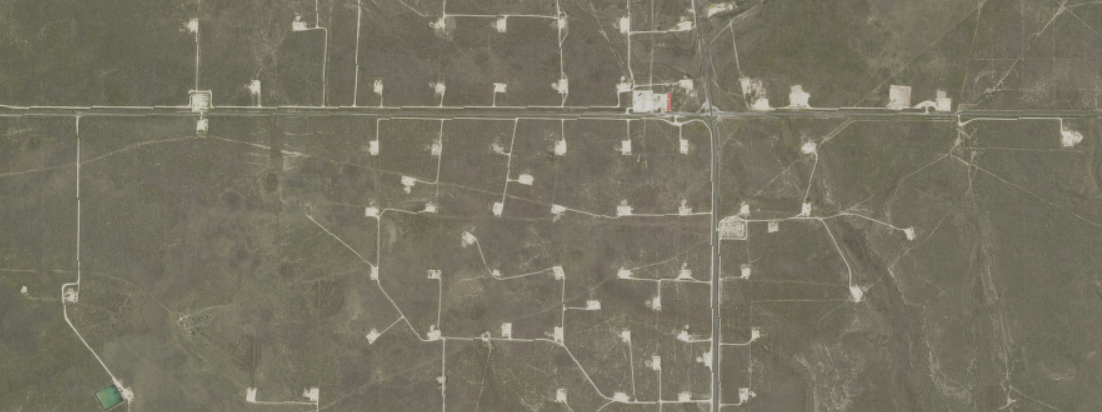

In [3]:
# import packages
import IPython
import ipywidgets
import ipyleaflet
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import os
import tensorflow as tf

import descarteslabs as dl
import descarteslabs.workflows as wf

from utils import make_ground_dataset_from_polygons, get_center_location
from unet import UNet

## 2. Data
____________________

Let's investigate the imagery and training data. Here we provide training labels as a set of hand-labeled well pads formatted in GeoJSON. Let's start by using `Workflows` to visualize the imagery and the training labels.

In [4]:
# change main params here for experimenting with different areas, resolutions, etc
config = {
    "labels": "../data/spatial/mumbai_slums_attempt2_split_largeonly.geojson",
    "resolution_m": 0.5,
    "tfrecords": "../data/tfrecords/mumbai_slums_attempt2_split_largeonly_50cm_256px.tfrecords",
    "model_dir": "../data/models/mumbai_model_data_split_large_50cm/",
    "storage_name": "mumbai_model_data_split_large_50cm",
    "source_imagery": "airbus:oneatlas:phr:v2",
    "from_date": "2017-01-01",
    "to_date": "2020-08-20",
    "predictions_catalog_slug": "nairobi-slums-from-mumbai-50cm"
    #mumbai_model_split_large_5m
}

In [5]:
with open(config['labels']) as f:
    fc = json.load(f)

In [6]:
len(fc['features'])

3585

There are 1000 labeled data points. Let's first look at the training labels on the NAIP imagery. A simple `Workflows` is created to view the base imagery and overlay the ground truth labels.

In [258]:
m1 = wf.interactive.MapApp()
m1.center = (19.1027, 72.8713)
#m1.center = (-1.3140, 36.7960)
m1.zoom = 14
geo_json = ipyleaflet.GeoJSON(data=fc,
                   style={'color': 'red', 'fillOpacity': 0.8},
                   hover_style={'fillOpacity': 0.5})
#m1.add_layer(geo_json)

img = wf.ImageCollection.from_id(config["source_imagery"],
                                 start_datetime=config["from_date"],
                                 end_datetime=config["to_date"]).pick_bands("red green blue")
my_mosaic = img.max(axis='images')
my_mosaic.visualize('image', scales=[(0, 255), (0, 255), (0, 255)], map=m1)

# Finally, visualize this AOI!
m1


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


Next, let's make a ground-truth dataset for training. The training data for this segmentation model will be comprised of images with corresponding target rasters of the same size. Targets are binary rasters where 1 indicates the presence of a ~~well pad~~ slum and 0 indicates the absence. The function below tiles the region covering the labels above, retrieves an image for each tile, and makes the corresponding target raster. We have chosen training tiles with a size configurable above~~64x64 pixels~~. For the purposes of this demo, we use the `Scenes` API to retrieve the PLEIADES imagery at a resolution ~~of 10 m/pixel~~ configurable above. These training data are saved as `TFRecords` for efficient model training.

This step will take 5-10 minutes since data are being retrieved on-the-fly. The dataset only has to be created once. In case the notebook is re-run, this cell can be skipped.
___

### Notes on slum modifications
Note that this simple function isn't really adequate for the slum detection so we need to develop it further. It's really conceived for things where the target of interest is smaller than the extent of the tile will be (given its chosen resolution and dimensions) and so will be fully covered in the produced tile. In particular for a given dataset of slum polygons:
- the function uses the centroid point of the polygons to place the tile so in the case of a big slum polygon there would only be one tile that may not cover it all. I've temporarily  reduced the impact of this by splitting the polygons themselves into parts that are approximately the same kind of size as the tiles will be but this isn't a great solution
- related to this the tiles will have relatively little coverage of non-slum areas: only the areas immediately adjacent to a slum within the tile's extent
- the tiles don't overlap except to the extent caused by any natural overlap of their extent dictated by the centroid points
- there is no augmentation of the samples i.e. they are all north-up. Each sample may benefit from being rotated a few times  (e.g. to reduce the effect of consistent shadow direction)

Ideally I'll either write a more comprehensive function for creating the samples within DL platform, OR export mosaiced Pleiades imagery to local machine and use this to create samples using a prerolled function such as those in ArcGIS or various online training sample generator tools


In [307]:
n_samples = make_ground_dataset_from_polygons(config['labels'],
                                              products=config['source_imagery'],
                                              bands=['red', 'green', 'blue'],
                                              resolution=config['resolution_m'],
                                              tilesize=256,
                                              pad=0,
                                              start_datetime=config["from_date"],
                                              end_datetime=config["to_date"],
                                              #out_file='replace') # replace with config["tfrecords"]
                                              out_file=config["tfrecords"])

In [309]:
n_samples

3585

In order to read the TFRecords the data structure and a parsing function is defined next.

In [310]:
# Define the features in the TFRecords file
features = {
    'image/image_data': tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channels': tf.io.FixedLenFeature([], tf.int64),
    'target/target_data': tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
    'target/height': tf.io.FixedLenFeature([], tf.int64),
    'target/width': tf.io.FixedLenFeature([], tf.int64),
    'target/channels': tf.io.FixedLenFeature([], tf.int64),
    'dltile': tf.io.FixedLenFeature([], tf.string)
}

In [311]:
def parse_example(example_proto):
    image_features = tf.io.parse_single_example(example_proto, features)
    
    img_height = tf.cast(image_features['image/height'], tf.int32)
    img_width = tf.cast(image_features['image/width'], tf.int32)
    img_channels = tf.cast(image_features['image/channels'], tf.int32)
    
    target_height = tf.cast(image_features['target/height'], tf.int32)
    target_width = tf.cast(image_features['target/width'], tf.int32)
    target_channels = tf.cast(image_features['target/channels'], tf.int32)
    
    image_raw = tf.reshape(tf.squeeze(image_features['image/image_data']),
                           tf.stack([img_height, img_width, img_channels]))
    
    target_raw = tf.reshape(tf.squeeze(image_features['target/target_data']),
                            tf.stack([target_height, target_width, target_channels]))
    
    dltile = tf.cast(image_features['dltile'], tf.string)
    return image_raw, target_raw, dltile

Let's create a simple data pipeline to visualize some samples from the dataset.

In [312]:
# Create a TFRecordDataset to read images from these TFRecords
data = tf.data.TFRecordDataset(config['tfrecords']) \
           .map(parse_example, num_parallel_calls=4)

data_viz = iter(data.batch(1))

count rows in tfrecords dataset

In [313]:
sum(1 for _ in iter(data.batch(1)))

3585

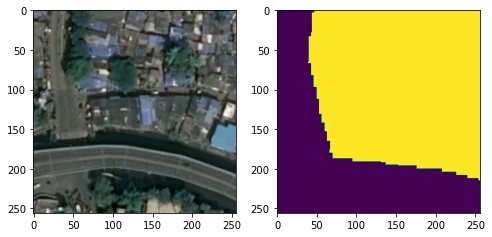

In [322]:
# Visualize samples. You can re-run this cell to iterate through the dataset.
img_tf, trg_tf, tile_tf = next(data_viz)
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(img_tf.numpy().astype(np.uint8)[0])
ax[1].imshow(trg_tf.numpy().astype(np.uint8)[0].squeeze())

In [326]:
tile_tf

<tf.Tensor: id=673591, shape=(1,), dtype=string, numpy=array([b'256:0:0.5:43:-1758:16630'], dtype=object)>

In [ ]:
img_tf.numpy().squeeze

In [320]:
# get the gdal geotransform of the representation of the tile as saved in tfrecord
def tensor_to_dl_tile(t):
    return dl.scenes.DLTile.from_key(eval(str(t.numpy()))[0].decode('utf-8'))
tensor_to_dl_tile(tile_tf)

DLTile(key='256:0:0.5:43:-1757:16631',
       resolution=0.5,
       tilesize=256,
       pad=0,
       crs='EPSG:32643',
       bounds=(275104.0, 2128768.0, 275232.0, 2128896.0),
       bounds_crs='EPSG:32643',
       geometry=<shapely.geom...x7f57410a4c50>,
       zone=43,
       ti=-1757,
       tj=16631,
       geotrans=[
  275104.0,...
  0,
  -0.5
],
       proj4='+proj=utm +z...s=m +no_defs ',
       wkt='PROJCS["WGS ...SG","32643"]]')

The above display shows the first training sample, displaying the image and corresponding target. Each image can have one or more well pads or can be a negative image without any. You can iterate through the training images by re-running the cell above multiple times.

## 3. Model
____________________

The model that we will be using is a [UNet classifier](https://arxiv.org/abs/1505.04597). We will use a pre-built implementation in Tensorflow / Keras.
Before you continue, make sure you are using [TensorFlow](https://www.tensorflow.org/) version `2`. 

In [323]:
# Build the model. We could just use the base_model but then the input size would be fixed
# once we load a saved model. In order to be able to predict on larger tiles we create an
# input layer with no fixed size
base_model = UNet()
inputs = tf.keras.layers.Input(shape=(None, None, 3))
model = tf.keras.Model(inputs=inputs, outputs=base_model(inputs))

Before we can train our model, we need to compile it with a loss function and optimizer. A reasonable choice of optimizer is [Adam](https://arxiv.org/abs/1412.6980v8) - it performs well in most real-world scenarios. We will use [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) as a loss as it is suitable for binary classification problems. 

### Notes on slum modifications
So far I have only adjusted learning rate, have not tried different optimizers / loss functions

In [324]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [325]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
u_net_7 (UNet)               (None, None, None, 1)     7760097   
Total params: 7,760,097
Trainable params: 7,760,097
Non-trainable params: 0
_________________________________________________________________


## 4. Training
______________________

We are now ready to train our model. Deep learning models are typically trained using stochastic gradient descent over batches of data. We will now setup the entire input pipeline using the Tensorflow Dataset API. Here we pre-process the data with a simple mean-subtraction transform. Additional transforms could be applied in the pipeline with the `.map()` function. Finally, the data is shuffled before splitting into a training and validation set.

### Notes on slum modifications

Have played around with batch size a bit (and obviously n_samples).
NB the data range of pleiades imagery is different (0-255) so the subtract_mean function was adjusted. Not sure if it's right to call it subtract_mean as the actual mean is not likely to be 128 just because that's the middle of the data range.

Should probably poke around with different normalisation functions. 

**See https://machinelearningmastery.com/gradient-descent-for-machine-learning/**
"the algorithm will reach the minumum cost faster if the shape of the cost function is not skewed and distorted"


In [331]:
# Define some transforms
def subtract_mean(feature, target):
    return feature - 128.0, target

def type_transform(feature, target,_):
    return tf.cast(feature, tf.float32), tf.cast(target, tf.float32)

In [332]:
transforms = [type_transform, subtract_mean]
batch_size = 8
n_samples = 3585
n_train_samples = int(0.8*n_samples)
n_val_samples = n_samples - n_train_samples

data = tf.data.TFRecordDataset(config['tfrecords']) \
           .map(parse_example, num_parallel_calls=4)

# Apply transforms
for t in transforms:
    data = data.map(t, num_parallel_calls=4)

# Shuffle the data and split into train and validation set
data = data.shuffle(buffer_size=1000)
data_train = data.take(n_train_samples) \
                 .repeat() \
                 .batch(batch_size)
data_val = data.skip(n_train_samples) \
               .repeat() \
               .batch(batch_size)

In [333]:
n_train_samples, n_val_samples


(2868, 717)

In [334]:
n_train_samples // batch_size

358

In [283]:
data_train

<BatchDataset shapes: ((None, None, None, None), (None, None, None, None)), types: (tf.float32, tf.float32)>

Now we train the model using the built-in model.fit() function. If this notebook is run on a server with a GPU attached, training over 100 epochs should take about 1.5 minutes and an accuracy of ~99.5% will be achieved. You can attach a GPU to your notebook by choosing the "Model Training" Server option when you start your Jupyter server.

In [335]:
history = model.fit(data_train,
                    steps_per_epoch=n_train_samples//batch_size,
                    validation_data=data_val,
                    validation_steps=n_val_samples//batch_size,
                    epochs=100)

Train for 358 steps, validate for 89 steps
Epoch 1/100
358/358 [==============================] - 100s 280ms/step - loss: 0.6810 - accuracy: 0.6139 - val_loss: 0.6648 - val_accuracy: 0.6169
Epoch 2/100
358/358 [==============================] - 96s 267ms/step - loss: 0.6576 - accuracy: 0.6189 - val_loss: 0.6214 - val_accuracy: 0.6768
Epoch 3/100
358/358 [==============================] - 96s 267ms/step - loss: 0.6168 - accuracy: 0.6737 - val_loss: 0.5643 - val_accuracy: 0.7228
Epoch 4/100
358/358 [==============================] - 96s 267ms/step - loss: 0.5411 - accuracy: 0.7390 - val_loss: 0.4876 - val_accuracy: 0.7713
Epoch 5/100
358/358 [==============================] - 95s 267ms/step - loss: 0.5091 - accuracy: 0.7578 - val_loss: 0.4925 - val_accuracy: 0.7522
Epoch 6/100
358/358 [==============================] - 95s 267ms/step - loss: 0.4869 - accuracy: 0.7737 - val_loss: 0.4811 - val_accuracy: 0.7655
Epoch 7/100
358/358 [==============================] - 95s 267ms/step - loss: 0.

In [336]:
# Save the model
tf.saved_model.save(model, config['model_dir'])

INFO:tensorflow:Assets written to: mumbai_model_data_split_large_50cm/assets


Upload this saved model to Storage so it can be accessed from anywhere, such as Tasks. Because TF2.0 models are saved as folders, we zip the saved model into a single file-like object before uploading.

In [337]:
!zip -r tmp_model_data.zip {config['model_dir']}
print('Upload model to Storage')
storage = dl.Storage()
storage.set_file(config['storage_name'], 'tmp_model_data.zip')
os.remove('tmp_model_data.zip')

  adding: mumbai_model_data_split_large_50cm/ (stored 0%)
  adding: mumbai_model_data_split_large_50cm/saved_model.pb (deflated 91%)
  adding: mumbai_model_data_split_large_50cm/assets/ (stored 0%)
  adding: mumbai_model_data_split_large_50cm/variables/ (stored 0%)
  adding: mumbai_model_data_split_large_50cm/variables/variables.data-00000-of-00002 (deflated 86%)
  adding: mumbai_model_data_split_large_50cm/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: mumbai_model_data_split_large_50cm/variables/variables.index (deflated 76%)
Upload model to Storage


Let's plot the training history. Our model's loss should go down smoothly while the accuracy should go up.

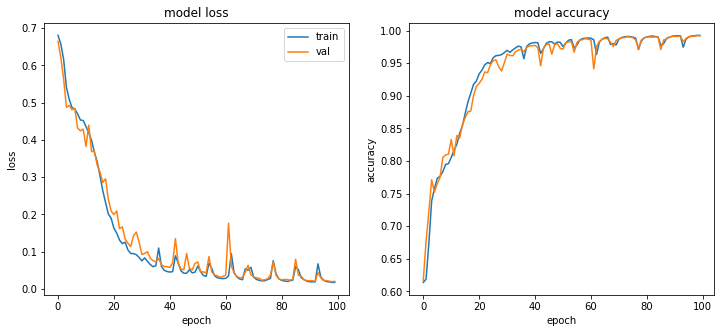

In [338]:
fig, ax = plt.subplots(1, 2,  figsize=(12, 5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='val')

ax[0].set_title('model loss')
ax[1].set_title('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[0].legend(loc='upper right')

plt.show()

In [339]:
min(history.history['val_loss'])

0.01870278107902307

## 5. Predictions
________________

Let's take a look at some predictions made by our model. We already saved the trained model to `Storage` above, allowing us to download and use the model locally here, or in `Tasks` in the following section.

In [340]:
def load_model_from_storage(storage_key):
    '''Load TF model from DL.Storage'''
    import tempfile
    from tensorflow.keras.models import load_model
    import descarteslabs as dl
    model_zip = tempfile.NamedTemporaryFile()
    model_dir = tempfile.TemporaryDirectory()
    dl.Storage().get_file(storage_key, model_zip.name)
    os.system('unzip {} -d {}'.format(model_zip.name, model_dir.name))
    model = load_model(os.path.join(model_dir.name, config['model_dir']))
    model_zip.close()
    model_dir.cleanup()
    
    return model

Here we retrieve an example image and preprocess it using the preprocessing function we used during training. We define a function that retrieves the image from the platform given the dltile key.

In [391]:
def get_image(dltile_key):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products=config['source_imagery'], 
                                start_datetime=config["from_date"],
                                end_datetime=config["to_date"],)
    im = sc.mosaic(bands='red green blue', ctx=ctx, bands_axis=-1)
    ids = [scene.properties.id for scene in sc]
    acquired_datetime = sc[-1].properties.date.isoformat() # grab the acquired date from the last scene
    
    metadata = {
        'acquired_datetime': acquired_datetime,
        'ids': ids,
    }
    
    return im, metadata

For simplicity, let's wrap all of the necessary steps into a single function that loads the model, retrieves an image for a location specified by `dltile_key`, pre-processes the image, performs model prediction, and post-processes the prediction.

In [392]:
def predict_image(dltile_key):
    print("Predict on image for dltile {}".format(dltile_key))
    
    # load model
    model = load_model_from_storage(config['storage_name'])
    
    # get imagery
    im, meta = get_image(dltile_key)
    
    # add batch dimension
    im = np.expand_dims(im, axis=0).astype(np.float32)
    
    # pre-process
    im, _ = subtract_mean(im, None)
    
    # predict
    pred = model.predict(im)
    
    # post-process
    pred = np.clip(255 * pred.squeeze(), 0, 255).astype('uint8')
    
    return im, pred, meta

In [351]:
lat, lon = 19.0161, 72.8540 
# addis lat, lon = 8.995, 38.7552
# kibera 
lat, lon = -1.3140, 36.7960
tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution=0.5, tilesize=256, pad=0)

im, pred, meta = predict_image(tile.key)

Predict on image for dltile 256:0:0.5:37:-1916:-1136


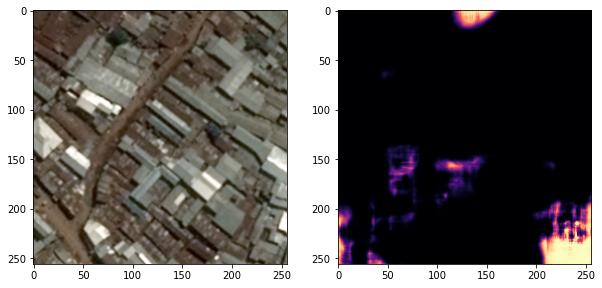

In [352]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow((im.squeeze()+128).astype('uint8'))
ax[1].imshow(pred.squeeze(), cmap='magma')

With any luck, the model should have detected the well pads. If the model isn't performing well, several additional epochs of training might be needed to improve the model to the level of accuracy required. Some improvements could be changing hyperparmeters, training time, or model architecture.

## 6. Deploying
______________

Once the trained model has satisfactory performance, we want to use the model to search a large region of interest for well pads. For large-scale inference, we recommend using Descartes Labs Tasks. The general workflow is:

* Create `Catalog` or `Vector` endpoint that will store inference results.
* Define a deployment function.
* Deploy over a region of interest using auto-scaling compute resources from `Tasks`.

Below we go through each of these steps in more detail.

### 6.1 Make Catalog Product

Here we make a catalog product to store our inference result. Below, we create a catalog product and add the appropriate bands. A catalog product must have a unique name, and because this demo might be run multiple times, we use a random string.

In [425]:
product_id = config["predictions_catalog_slug"] + str(random.randint(1000,9999))
product_id = "capetown-slums-from-mumbai-50cm-" + str(random.randint(1000,9999))
# The product ID will be passed to the deployment function and will allow us to
# upload data to this specific product with Tasks.
print("Create product with Catalog product id {}".format(product_id))

Create product with Catalog product id capetown-slums-from-mumbai-50cm-8611


In [426]:
product = dl.catalog.Product.get(id=dl.catalog.Product.namespace_id(product_id))
if isinstance(product, type(None)):
    print("Catalog product {} not found. Making new product".format(product_id))
    product = dl.catalog.Product(
        id=product_id,
        name="Capetown Slum Demo",
        description="Slum delineation in Capetown with 50cm-res Mumbai model"
    )
    product.save()
    # bands
    band = dl.catalog.GenericBand(
        name="p_slum",
        product=product,
        data_type=dl.catalog.DataType.BYTE,
        data_range=(0, 255),
        display_range=(0, 255),
        resolution=dl.catalog.Resolution(
            unit=dl.catalog.ResolutionUnit.METERS, value=10,
        ),
        band_index=0,
        colormap_name="magma",
        nodata=0,
    )
    band.save()
else:
    print("Found existing product {}".format(product_id))
full_product_id = product.id

Catalog product capetown-slums-from-mumbai-50cm-8611 not found. Making new product


The product ID will be passed to the deployment function and will allow us to upload data to this specific product with Tasks.

Now that we have added the band to the catalog, we can check that the product is initialized by checking the [Catalog User Interface](https://catalog.descarteslabs.com/?/filter/my). It is now ready to store data.

In [396]:
IPython.display.IFrame(src='https://catalog.descarteslabs.com/?/filter/my', width=1200, height=400, scrolling='yes')

### 6.2 Define a deployment function

Here we define the function that will be run over each tile in our region of interest. This function retrieves the model from Storage, gets imagery from the Descartes Labs Scenes service, runs model inference, post-processes the output, and finally uploads to the Catalog product we just created.

In [397]:
def predict_slum(dltile_key, catalog_pid, upload=True):
    import descarteslabs as dl
    from descarteslabs.catalog import Product, Image, OverviewResampler
    
    tile = dl.scenes.DLTile.from_key(dltile_key)
    
    im, pred, meta = predict_image(dltile_key)
    product = Product.get(catalog_pid)
    # Upload result to Catalog
    if upload:
        print("Upload to catalog {}".format(catalog_pid))
        image = Image(product=product, name=tile.key.replace(":","_"))
        image.geotrans = tile.geotrans
        image.projection = tile.proj4
        image.acquired = meta['acquired_datetime']
        image.upload_ndarray(
            ndarray=pred,
            overviews=[2, 4],
            overview_resampler=OverviewResampler.AVERAGE
        )
    print("Success")
    return pred

It is useful to first run this code locally to debug your function.

In [373]:
lat, lon = 19.0476, 72.8943
tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution=0.5, tilesize=512, pad=0)
pred = predict_slum(tile.key, full_product_id, upload=False)

Predict on image for dltile 512:0:0.5:43:-866:8232
Success


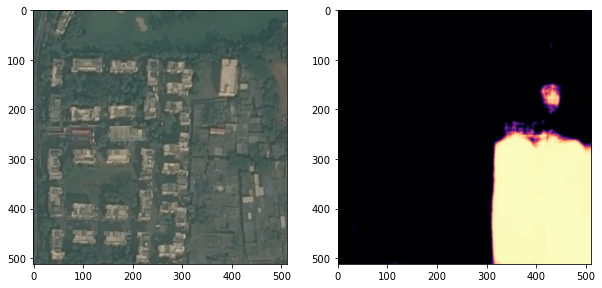

In [374]:
im, meta = get_image(tile.key)
fig, ax = plt.subplots(1, 2, figsize=(10,8))
ax[0].imshow(im)
ax[1].imshow(pred.squeeze(), cmap='magma')

### 6.3 Make a Task Group

Now we will finish our deployment script. It will load the model, retrieve tiled imagery over the region of interest, process the imagery, predict, and upload to the catalog we created above. We will store the output of this semantic segmentation model as a probability raster.

First, we choose a docker image for this task. Jobs in `Tasks` are run inside a docker container that the user can specify. A few things to note:
* The python version of the Task image must match the version of python you are using locally. Here, this notebook is running in Python 3.7, so we choose a matching Task image.
* Available public images can be found [here](https://docs.descarteslabs.com/guides/tasks.html#choosing-your-environment).
* Users can pass additional modules without needing to modify the docker container using the `include_modules` keyword. See [documentation](https://docs.descarteslabs.com/guides/tasks.html) for details.

In [375]:
# Python 3.7
#docker_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.7:v2020.01.21-7-g309186be'
docker_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.7-gpu:v2020.08.20-10-gaec3dd13'

Next, we can create a Task group to accept jobs.

In [427]:
tasks = dl.Tasks()
async_predict = tasks.create_function(
    f=predict_slum,
    name='slums-demo-deploy',
    image=docker_image
    #maximum_concurrency=200
)

The task group is now ready to receive work.

### 6.4 Deploy

Let's deploy our model over a new region in Texas. Like before, we can define an area of interest and divide that area into tiles. Those tiles are sent to Tasks one at a time to be executed in parallel.

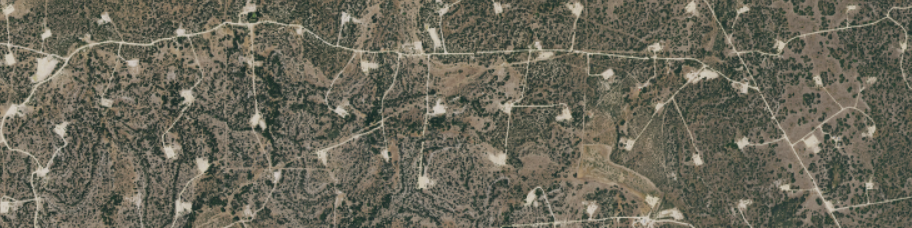

In [423]:
# https://boundingbox.klokantech.com/

aoi_mumbai = {"type":"Feature","geometry":{"type":"Polygon","coordinates":[[
    [72.7742,19.2278],
    [72.9715,19.2278],
    [72.9715,18.9077],
    [72.7742,18.9077],
    [72.7742,19.2278]]]},
      "properties":{}}

aoi_nairobi = {"type":"Feature","geometry":{"type":"Polygon","coordinates":[
    [[36.6703888044,-1.3406311919],
     [36.9677063093,-1.3406311919],
     [36.9677063093,-1.1889195498],
     [36.6703888044,-1.1889195498],
     [36.6703888044,-1.3406311919]]]},
      "properties":{}}


#aoi_capetown= {"type":"Feature","geometry":{"type":"Polygon","coordinates":[
#    [[18.30721995,-34.35834006],
#     [18.8128342458,-34.35834006],
#     [18.8128342458,-33.7796671786],
#     [18.30721995,-33.7796671786],
#     [18.30721995,-34.35834006]]]},
#     "properties":{}}

aoi_capetown= {"type":"Feature","geometry":{"type":"Polygon","coordinates":[
                                        [[18.458181841,-34.2172877143],[18.4368958303,-34.2022398118],[18.4186997243,-34.2093382138],[18.3805908986,-34.2076346518],[18.3665146657,-34.1965606598],[18.3445420095,-34.1789528577],[18.3201660939,-34.1641821897],[18.3143296071,-34.1326438478],[18.3356156179,-34.1246863704],[18.3500351735,-34.0894371111],[18.3627381154,-34.0644125998],[18.3558716603,-34.0513286631],[18.3253159352,-34.0649814208],[18.2995667287,-34.0339751107],[18.3170761891,-34.0160488624],[18.3651413747,-33.9593998177],[18.3840241262,-33.9010032912],[18.413549883,-33.8935940418],[18.4478821584,-33.9018581632],[18.4674515554,-33.8950189475],[18.4815277883,-33.8690819388],[18.4726013967,-33.8263114227],[18.4578385182,-33.8066297965],[18.439985735,-33.7903676464],[18.4897675344,-33.775529306],[18.5663285085,-33.7795244967],[18.5567154714,-33.8086266897],[18.6137070485,-33.8208922963],[18.6473526784,-33.8052034158],[18.6779084035,-33.8034917275],[18.7180771657,-33.8131908418],[18.7496628591,-33.8183252219],[18.766485674,-33.8408558005],[18.7510361501,-33.8784885783],[18.7163605519,-33.8924541001],[18.7033142873,-33.9235120603],[18.7294068166,-33.9656643825],[18.7476029225,-33.9989727249],[18.7778153249,-34.0297072998],[18.7819351979,-34.0342596238],[18.8234772512,-34.0373892049],[18.8602127858,-34.0646970108],[18.8972916432,-34.0925646551],[18.9202942678,-34.1158754325],[18.9075913259,-34.1621936332],[18.857122881,-34.1613413803],[18.8004746266,-34.1013780211],[18.7084641286,-34.0774945166],[18.6288132497,-34.0780632498],[18.5409226247,-34.0973979049],[18.4890808888,-34.1093376918],[18.4506287404,-34.1329280296],[18.4420456716,-34.1556594748],[18.4310593434,-34.1852012082],[18.458181841,-34.193152985],[18.4691681691,-34.2161521173],[18.458181841,-34.2172877143]
]]},
     "properties":{}}

aoi = aoi_capetown
tiles = dl.scenes.DLTile.from_shape(aoi, tilesize=512, resolution=0.5, pad=0)
# NB the currently saved mumbai model was done with resolution 10 by mistake (but trained on 5) so if it's good then that's a miracle
print("Found {} dltiles in this AOI.".format(len(tiles)))

Found 20603 dltiles in this AOI.


In [252]:
tiles[0]

DLTile(key='128:0:5.0:37:-406:-232',
       resolution=5.0,
       tilesize=128,
       pad=0,
       crs='EPSG:32637',
       bounds=(240160.0, -148480.0, 240800.0, -147840.0),
       bounds_crs='EPSG:32637',
       geometry=<shapely.geom...x7f5741edec50>,
       zone=37,
       ti=-406,
       tj=-232,
       geotrans=[
  240160.0,...
  0,
  -5.0
],
       proj4='+proj=utm +z...s=m +no_defs ',
       wkt='PROJCS["WGS ...SG","32637"]]')

In [424]:
m1 = wf.interactive.MapApp()
m1.center = (19.1, 72.87)
m1.center = (-1.3140, 36.7960)
m1.zoom = 11
geo_json = ipyleaflet.GeoJSON(
    data=aoi,
    style={'color': 'green', 'fillOpacity': 0.3},
    hover_style={'fillOpacity': 0.5})
m1.add_layer(geo_json)

img = wf.ImageCollection.from_id(config["source_imagery"],start_datetime=config['from_date'], end_datetime=config['to_date']).pick_bands("red green blue")
my_mosaic = img.max(axis='images')
my_mosaic.visualize('image', scales=[(0, 255), (0, 255), (0, 255)], map=m1)

# Finally, visualize this AOI!
m1


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


Run this job in Tasks!

In [429]:
for tile in tiles:
    async_predict(tile.key, full_product_id)

As before we can monitor the status of our Task through the client or online. 

## 7. Results
_______________

As the Tasks are being completed, we can retrieve the data as it arrives.

In [170]:
IPython.display.IFrame(src='https://monitor.descarteslabs.com/', width=1200, height=700, scrolling='yes')

Once the Tasks above have finished, let's visualize the model results. We can load the model raster output on top of the imagery used to predict.

In [430]:
# Set up basemap using Descartes Labs Workflows
m2 = wf.interactive.MapApp()
#m2.center = (19.1, 72.87)
m2.center = (-1.3140, 36.7960)
m2.zoom = 14

# Add NAIP imagery to the map
img = wf.ImageCollection.from_id(config["source_imagery"],config["from_date"], config["to_date"]).pick_bands("red green blue")
#my_mosaic = img.max(axis='images')
my_mosaic = img.mosaic()
my_mosaic.visualize('image', scales=[(0, 255), (0, 255), (0, 255)], map=m2)

# Add Model probability to the map
img = wf.ImageCollection.from_id(
    #"peak-urban:mumbai-slums-50cm7700",
    full_product_id, 
    config["from_date"], config["to_date"]).pick_bands("p_slum")
mosaic = img.median(axis='images')
mosaic = mosaic.mask(mosaic < 50) # Apply threshold to the probability map
mosaic.visualize('probability', scales=[(0,255)], colormap="magma", map=m2, checkerboard=False)

#Show boundary of the AOI we searched
geo_json = ipyleaflet.GeoJSON(data=aoi, style={'color': 'yellow', 'fillOpacity': 0})
m2.add_layer(geo_json)

# show original input features
labels = ipyleaflet.GeoJSON(data=fc,
                   style={'color': 'red', 'fillOpacity': 0.1},
                   hover_style={'fillOpacity': 0.2})
#m2.add_layer(labels)

In [431]:
# Finally, visualize this map
m2


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


## 8. Wrap-Up
__________

In this notebook, we have worked through a complete example of training and using a deep-learning classifier. Starting with vectorized ground truth, we pulled imagery from the Descartes Labs platform to create raster training data.  We then created a semantic segmentation model that classifies the presence of oil & gas well pads and trained that model locally on a GPU.  We used Descartes Labs Tasks to deploy our model across a test area and used Workflows to visualize the results. This example notebook can serve as a starting point for developing a wide variety of machine learning and computer vision tasks on the Descartes Labs platform.

## Resources
______________________

[1] [Scenes Documentation](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html)

[2] [Tasks Documentation](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html)

[3] [Workflows Documentation](https://docs.descarteslabs.com/guides/workflows.html)

[4] [Tensorflow Documentation](https://www.tensorflow.org/guide)